# Multi-agent reinforcement learning(Collaboration and Competition)

---
Based on paper [Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments](https://arxiv.org/pdf/1706.02275.pdf)

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch as torch
import torch.nn.functional as F
from torch import optim as optim
import matplotlib.pyplot as plt
from collections import namedtuple,deque
import random
import copy

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations        # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.10000000149011612
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [8]:
REPLAY_BUFFER_SIZE = int(1e6)
VISUALIZE_EVERY = 50 #how many episodes to train before watching unity env simulation
PRINT_EVERY = 10 #how many steps to train before printing training info
DESIRED_EPISODES_AVERAGE = 100
DESIRED_AVERAGE_SCORE = 0.5
TRAIN_EVERY = 1
BATCH_SIZE = 128
UPDATE_TARGET_NETWORK_EVERY = 10
TAU = 1.0 
SEED=0
EPISODES = 5000
ACTOR_LR = 1e-3
CRITIC_LR = 2e-3
CRITIC_CLIP = 0.5
EXPLORATION_EPISODES = 100

REPLAY_BUFFER_SIZE = int(1e6)
VISUALIZE_EVERY = 50 #how many episodes to train before watching unity env simulation
PRINT_EVERY = 10 #how many steps to train before printing training info
DESIRED_EPISODES_AVERAGE = 100
DESIRED_AVERAGE_SCORE = 0.5
TRAIN_EVERY = 2
BATCH_SIZE = 128
UPDATE_TARGET_NETWORK_EVERY = TRAIN_EVERY
TAU = 3e-3 
SEED=0
EPISODES = 5000
ACTOR_LR = 1e-3
CRITIC_LR = 2e-3
CRITIC_CLIP = 0.5
EXPLORATION_EPISODES = 100

In [9]:
torch.manual_seed(SEED)
np.random.seed(SEED)

In [10]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples for experience replay"""
    
    def __init__(self,action_size,buffer_size):
        """Initialize a ReplayBuffer objectParams
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
        """
        
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience",field_names=["all_state", "all_action", "all_reward","all_next_state", "done"])
        
    def add(self,all_state,all_action,all_reward,all_next_state,done):
        "Add a new experience tuple to replay buffer"
        new_experience = self.experience(all_state,all_action,all_reward,all_next_state,done)
        self.memory.append(new_experience)
        
    def sample(self,batch_size):
        "Get a sample of the buffer of size=batch size"
        experience_batch = random.sample(self.memory,k=batch_size)
        
        #states =  torch.from_numpy(np.vstack([e.state  for e in experience_batch if e is not None])).float().to(device)
        all_states = torch.from_numpy(np.vstack([e.all_state.reshape(1,2,-1) for e in experience_batch if e is not None])).float().to(device)
        #actions = torch.from_numpy(np.vstack([e.action for e in experience_batch if e is not None])).float().to(device)
        all_actions = torch.from_numpy(np.vstack([e.all_action.reshape(1,2,-1) for e in experience_batch if e is not None])).float().to(device)
        all_rewards = torch.from_numpy(np.vstack([e.all_reward.reshape(1,2,-1) for e in experience_batch if e is not None])).float().to(device)
        #next_states = torch.from_numpy(np.vstack([e.next_state for e in experience_batch if e is not None])).float().to(device)
        all_next_states = torch.from_numpy(np.vstack([e.all_next_state.reshape(1,2,-1) for e in experience_batch if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done.astype(np.uint8).reshape(1,2,-1) for e in experience_batch if e is not None]).astype(np.uint8)).float().to(device)
        
        return (all_states,all_actions,all_rewards,all_next_states,dones)
    
    def __len__(self):
        """Return the current size of internal memory"""
        return len(self.memory)

In [11]:
class OUNoise:
    """
        Orstein-Ulenbeck process
        used to add noise to actor selections for adding exploratoion
    """
    def __init__(self,size,mu=0.0,theta=0.15,sigma=0.2):
        self.size = size
        self.mu = mu*np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()
        
    def reset(self):
        self.state = copy.copy(self.mu)
        
    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        
        return self.state

In [12]:
def hidden_init(layer):
    """Used to set the initial weights of hidden layers"""
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

In [13]:

# one actor will be shared by the 2 players, trained by self-play
class Actor(torch.nn.Module):
    def __init__(self,state_size,action_size):
        super(Actor,self).__init__()
        self.action_size = action_size
        self.bn=   torch.nn.BatchNorm1d(state_size)
        self.fc1 = torch.nn.Linear(state_size,128)
        self.fc2 = torch.nn.Linear(128,128)
        self.fc_output = torch.nn.Linear(128,action_size)
        self.reset_parameters()
        
    def forward(self,x):
        x = self.bn(x.contiguous())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        y = F.tanh(self.fc_output(x))
        
        return y
    
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc_output.weight.data.uniform_(-0.0001, 0.0001)

In [14]:
# one critic will be shared by the 2 players, trianed by self-play
class Critic(torch.nn.Module):
    def __init__(self,state_size,action_size):
        super(Critic,self).__init__()
        self.fc1 = torch.nn.Linear(2*state_size+ 2*action_size,128) #use actions of both agent
        self.fc2 = torch.nn.Linear(128,128)
        self.fc_output = torch.nn.Linear(128,1)
        self.reset_parameters()
        
    def forward(self,x,actions):
        x = torch.cat((x,actions),dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        y = self.fc_output(x)
        
        return y
    
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc_output.weight.data.uniform_(-3e-4, 3e-4)

In [15]:
class Agent:
    
    agent1 = None
    agent2 = None
    
    def __init__(self,agent_index,state_size,action_size,replay_buffer,noise,device):
        self.agent_index = agent_index
        self.state_size = state_size
        self.action_size  = action_size
        self.actor_local = Actor(state_size,action_size).to(device)
        self.critic_local = Critic(state_size,action_size).to(device)

        self.actor_target = Actor(state_size,action_size).to(device)
        self.critic_target = Critic(state_size,action_size).to(device)

        self.update_target_networks(1.0)

        self.critic_optimizer = optim.Adam(self.critic_local.parameters(),lr=CRITIC_LR )
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(),lr=ACTOR_LR)
        
        self.device = device
        
        self.replay_buffer = replay_buffer
        
        self.noise = noise
        
        self.actor_local.eval()
        
    def act(self,state):
        
        state = torch.from_numpy(state).float().unsqueeze(0).detach().to(self.device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
            
        self.actor_local.train()
        noise = self.noise.sample()
        action = np.clip(action + noise ,-1,1)
        
        return action
    
    def update_target_network(self,local_network,target_network,tau):
        for target_param,local_param in zip(target_network.parameters(),local_network.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0 - tau)*target_param.data)
            
    def update_target_networks(self,tau):
        self.update_target_network(self.critic_local,self.critic_target,tau)
        self.update_target_network(self.actor_local,self.actor_target,tau)
            
            
    def train(self,batch_size=32,step_num=0,print_every = 100,critic_losses=[],actor_losses = []):
        (states, actions, rewards, next_states, dones) = self.replay_buffer.sample(batch_size)
        
        all_states = states.view((batch_size,2*self.state_size))
        all_next_states = next_states.view((batch_size,2*self.state_size))
        all_actions = actions.view((batch_size,2*self.action_size))
        
        
        agent1_next_states = next_states[:,0,:]
        agent2_next_states = next_states[:,1,:]
        
        agent1_states = states[:,0,:]
        agent2_states = states[:,1,:]
        
        states = states[:,self.agent_index,:]
        actions = actions[:,self.agent_index,:]
        rewards = rewards[:,self.agent_index,:]
        next_states = next_states[:,self.agent_index,:]
        dones = dones[:,self.agent_index,:]
        
        
        
        
        #actor_target.eval()
        #critic_target.eval()

        
        agent1_next_actions = self.agent1.actor_target(agent1_next_states)
        agent2_next_actions = self.agent2.actor_target(agent2_next_states)
        all_next_actions = torch.cat((agent1_next_actions,agent2_next_actions),dim=1)
        
        with torch.no_grad():
            #next_target_actions = actor_target(next_states)
            target_q_values = self.critic_target(all_next_states,all_next_actions)
        target_return = rewards + (0.99*target_q_values*(1-dones))

        #train critic
        #critic_local.train()

        current_critic_estimate = self.critic_local(all_states,all_actions)
        critic_mse_loss = F.mse_loss(current_critic_estimate,target_return.detach())
        

        self.critic_optimizer.zero_grad()
        critic_mse_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(),CRITIC_CLIP)
        self.critic_optimizer.step()

        critic_losses.append(critic_mse_loss.cpu().data.numpy())

        #train actor
        """local_actions = self.actor_local(states)
        all_actions_clone = all_actions.clone()
        actions_start_index = self.agent_index*self.action_size
        actions_end_index = actions_start_index + self.action_size         
        all_actions_clone[:,actions_start_index:actions_end_index] = local_actions
        all_actions_local = all_actions_clone
        """
        
        agent1_local_actions = self.actor_local(agent1_states)
        agent2_local_actions = self.actor_local(agent2_states)
        all_actions_local = torch.cat((agent1_local_actions,agent2_local_actions),dim=1)
        
        actor_loss = -self.critic_local(all_states,all_actions_local).mean()
       
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        actor_losses.append(actor_loss.cpu().data.numpy())
        
    def set_adversary_agent(self,other_agent):
        self.adversary_agent = other_agent

In [16]:
replay_buffer = ReplayBuffer(action_size,REPLAY_BUFFER_SIZE)
noise = OUNoise(size=action_size)

agent1 = Agent(0,state_size,action_size,replay_buffer,noise,device)
agent2 = Agent(1,state_size,action_size,replay_buffer,noise,device)

Agent.agent1 = agent1
Agent.agent2 = agent2

In [17]:
def main(agent1,agent2,noise,episodes,visualize_every,print_every):
    total_rewards = [[],[]]
    critic_losses = []
    actor_losses = []
    
    ag2_critic_losses = []
    ag2_actor_losses = []
    
    episode_single_scores = [] # the max between scores of both agents
    episode_window_scores = deque(maxlen = DESIRED_EPISODES_AVERAGE)
    
    for episode in range(1,episodes +1):
        finished = False
        step_count = 0
        episode_scores = np.zeros((num_agents,1))
        
        noise.reset()
        
        train_mode = not(episode%visualize_every == 0)
        env_info = env.reset(train_mode = train_mode)[brain_name]
        states = env_info.vector_observations
        
        while not finished:
            all_states = np.concatenate(states)
            actions_ag1 = agent1.act(states[0])
            actions_ag2 = agent2.act(states[1])
            
            all_actions = np.concatenate((actions_ag1,actions_ag2),axis = 0)
            
            env_info = env.step(all_actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = np.expand_dims(env_info.rewards,axis=1)
            dones = np.array(env_info.local_done)
            
            all_next_states = np.concatenate(next_states)
            #add experience to shared replay buffer
            #if np.sum(rewards) != 0.0:
            #print(states.shape,all_actions.shape,rewards.shape,next_states.shape,dones)
            replay_buffer.add(states,all_actions,rewards,next_states,dones)
            
            states = next_states
            
            episode_scores += rewards
            finished = dones[0] or dones[1]
            
            if step_count % TRAIN_EVERY == 0 and len(replay_buffer) >= BATCH_SIZE and episode >= EXPLORATION_EPISODES:
                agent1.train(batch_size = BATCH_SIZE, critic_losses = critic_losses,actor_losses = actor_losses)
                agent2.train(batch_size = BATCH_SIZE , critic_losses=   ag2_critic_losses,actor_losses = ag2_actor_losses)
                
            if step_count % UPDATE_TARGET_NETWORK_EVERY == 0 and len(replay_buffer) >= BATCH_SIZE and episode >= EXPLORATION_EPISODES:
                agent1.update_target_networks(TAU)
                agent2.update_target_networks(TAU)
                #update_target_network(actor_local,actor_target,TAU)
                #update_target_network(critic_local,critic_target,TAU)
                
            step_count += 1
            
            
        episode_single_score = max(episode_scores)[0]
        episode_window_scores.append(episode_single_score)
        episode_single_scores.append(episode_single_score)
        
        total_rewards[0].append(episode_scores[0])
        total_rewards[1].append(episode_scores[1])
        
        if episode % print_every == 0:
            print("Episode:{} steps:{} episode_reward:{} last n mean rew.{},individual episode rew.{}".format(episode, step_count,
                                                                                    episode_single_score,np.mean(episode_window_scores),episode_scores))
                
        
        if np.mean(episode_window_scores) >= DESIRED_AVERAGE_SCORE:
            print("Solved in {} episodes".format(episode))
            checkpoint_name = "checkpoint_solved_"+str(episode)+".pth"
            break
            
    return total_rewards,critic_losses,actor_losses,episode_single_scores,ag2_critic_losses,ag2_actor_losses

train_rewards,critic_losses,actor_losses,episode_single_scores,ag2_critic_losses,ag2_actor_losses = main(agent1,agent2,noise,
                                                                                                         EPISODES,VISUALIZE_EVERY,PRINT_EVERY)

Episode:10 steps:14 episode_reward:0.0 last n mean rew.0.009000000171363353,individual episode rew.[[ 0.  ]
 [-0.01]]
Episode:20 steps:14 episode_reward:0.0 last n mean rew.0.004500000085681677,individual episode rew.[[-0.01]
 [ 0.  ]]
Episode:30 steps:14 episode_reward:0.0 last n mean rew.0.00966666682312886,individual episode rew.[[-0.01]
 [ 0.  ]]
Episode:40 steps:15 episode_reward:0.0 last n mean rew.0.009750000154599547,individual episode rew.[[ 0.  ]
 [-0.01]]
Episode:50 steps:14 episode_reward:0.0 last n mean rew.0.007800000123679638,individual episode rew.[[ 0.  ]
 [-0.01]]
Episode:60 steps:33 episode_reward:0.10000000149011612 last n mean rew.0.01150000017757217,individual episode rew.[[ 0.1 ]
 [-0.01]]
Episode:70 steps:14 episode_reward:0.0 last n mean rew.0.011285714459206377,individual episode rew.[[-0.01]
 [ 0.  ]]
Episode:80 steps:14 episode_reward:0.0 last n mean rew.0.00987500015180558,individual episode rew.[[-0.01]
 [ 0.  ]]
Episode:90 steps:14 episode_reward:0.0 last

Episode:680 steps:31 episode_reward:0.09000000171363354 last n mean rew.0.07430000118911266,individual episode rew.[[0.  ]
 [0.09]]
Episode:690 steps:30 episode_reward:0.10000000149011612 last n mean rew.0.07920000124722719,individual episode rew.[[ 0.1 ]
 [-0.01]]
Episode:700 steps:30 episode_reward:0.09000000171363354 last n mean rew.0.0838000013306737,individual episode rew.[[0.  ]
 [0.09]]
Episode:710 steps:36 episode_reward:0.10000000149011612 last n mean rew.0.08460000135004521,individual episode rew.[[ 0.1 ]
 [-0.01]]
Episode:720 steps:30 episode_reward:0.09000000171363354 last n mean rew.0.08750000139698386,individual episode rew.[[0.  ]
 [0.09]]
Episode:730 steps:33 episode_reward:0.10000000149011612 last n mean rew.0.08940000142902135,individual episode rew.[[ 0.1 ]
 [-0.01]]
Episode:740 steps:30 episode_reward:0.09000000171363354 last n mean rew.0.09020000144839287,individual episode rew.[[0.  ]
 [0.09]]
Episode:750 steps:29 episode_reward:0.10000000149011612 last n mean rew

Episode:1300 steps:261 episode_reward:0.7000000104308128 last n mean rew.0.3241000048816204,individual episode rew.[[0.70000001]
 [0.59000001]]
Episode:1310 steps:337 episode_reward:0.9000000134110451 last n mean rew.0.3400000051222742,individual episode rew.[[0.90000001]
 [0.79000001]]
Episode:1320 steps:166 episode_reward:0.4000000059604645 last n mean rew.0.35280000532045963,individual episode rew.[[0.39000001]
 [0.40000001]]
Episode:1330 steps:236 episode_reward:0.6000000089406967 last n mean rew.0.35990000542253253,individual episode rew.[[0.60000001]
 [0.59000001]]
Episode:1340 steps:176 episode_reward:0.4000000059604645 last n mean rew.0.4182000062800944,individual episode rew.[[0.40000001]
 [0.39000001]]
Episode:1350 steps:182 episode_reward:0.5000000074505806 last n mean rew.0.43850000655278565,individual episode rew.[[0.50000001]
 [0.39000001]]
Episode:1360 steps:145 episode_reward:0.30000000447034836 last n mean rew.0.47150000704452394,individual episode rew.[[0.29]
 [0.3 ]]

In [18]:
for i in range(1, 10):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    agent1.noise.reset()
    agent2.noise.reset()
    while True:
        
        actions_ag1 = agent1.act(states[0])
        #actions_ag1 = [[1,-1]]
        actions_ag2 = agent2.act(states[1])
        #actions_ag2 = np.random.randn(1, action_size)
        #actions_ag2 = [[1,-1]]
        #print(actions_ag1,actions_ag2)
        env_info = env.step(np.concatenate((actions_ag1,actions_ag2),axis=0))[brain_name]
        next_states = env_info.vector_observations        # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        #print(states[0],states[1])
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.10000000149011612
Score (max over agents) from episode 2: 2.2000000327825546
Score (max over agents) from episode 3: 0.09000000171363354
Score (max over agents) from episode 4: 0.9000000134110451
Score (max over agents) from episode 5: 2.600000038743019
Score (max over agents) from episode 6: 0.6000000089406967
Score (max over agents) from episode 7: 0.10000000149011612
Score (max over agents) from episode 8: 0.10000000149011612
Score (max over agents) from episode 9: 0.10000000149011612


#### Agent 1 rewards

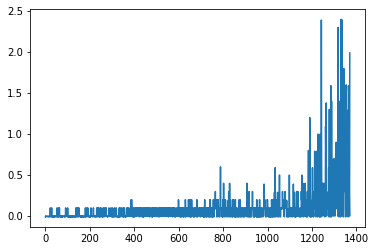

In [19]:
plt.plot(train_rewards[0])
plt.show()

#### Agent 2 rewards

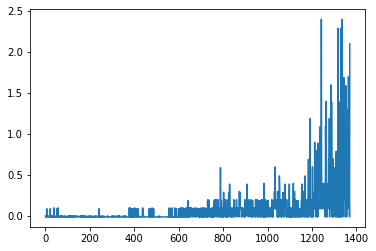

In [20]:
plt.plot(train_rewards[1])
plt.show()

### episode rewards

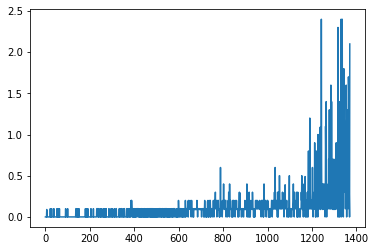

In [21]:
plt.plot(episode_single_scores)
plt.show()

#### Critic losses

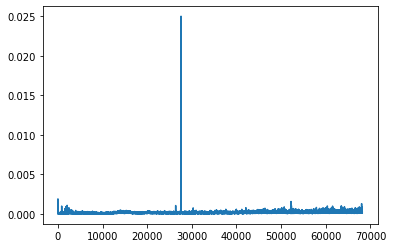

In [22]:
plt.plot(critic_losses)
plt.show()

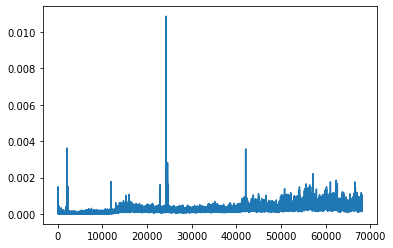

In [23]:
plt.plot(ag2_critic_losses)
plt.show()

### Actor losses

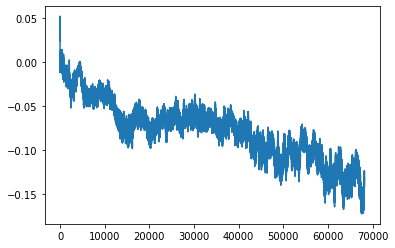

In [24]:
plt.plot(actor_losses)
plt.show()

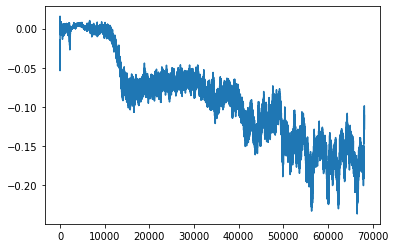

In [25]:
plt.plot(ag2_actor_losses)
plt.show()